Using device: cuda


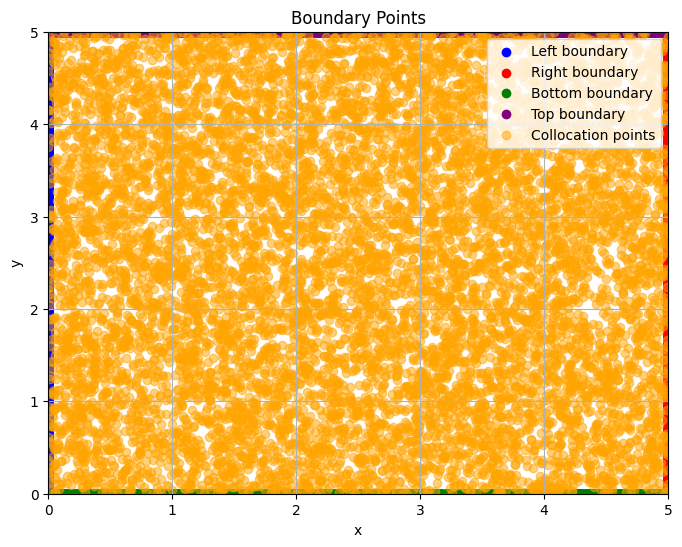

Left boundary: tensor([[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[1.8727],
        [4.7536],
        [3.6600],
        ...,
        [4.3279],
        [4.9037],
        [2.0379]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[0.8275],
        [0.7645],
        [0.5735],
        ...,
        [0.3278],
        [0.8157],
        [0.5973]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Right boundary: tensor([[5.],
        [5.],
        [5.],
        ...,
        [5.],
        [5.],
        [5.]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[1.9682],
        [2.3672],
        [4.2727],
        ...,
        [4.2516],
        [1.0643],
        [3.3438]], device='cuda:0', grad_fn=<ToCopyBackward0>) tensor([[0.5429],
        [0.8329],
        [0.1251],
        ...,
        [0.9467],
        [0.3975],
        [0.2171]], device='cuda:0', grad_fn=<ToCopyBackward0>)
Bottom boundary: tens

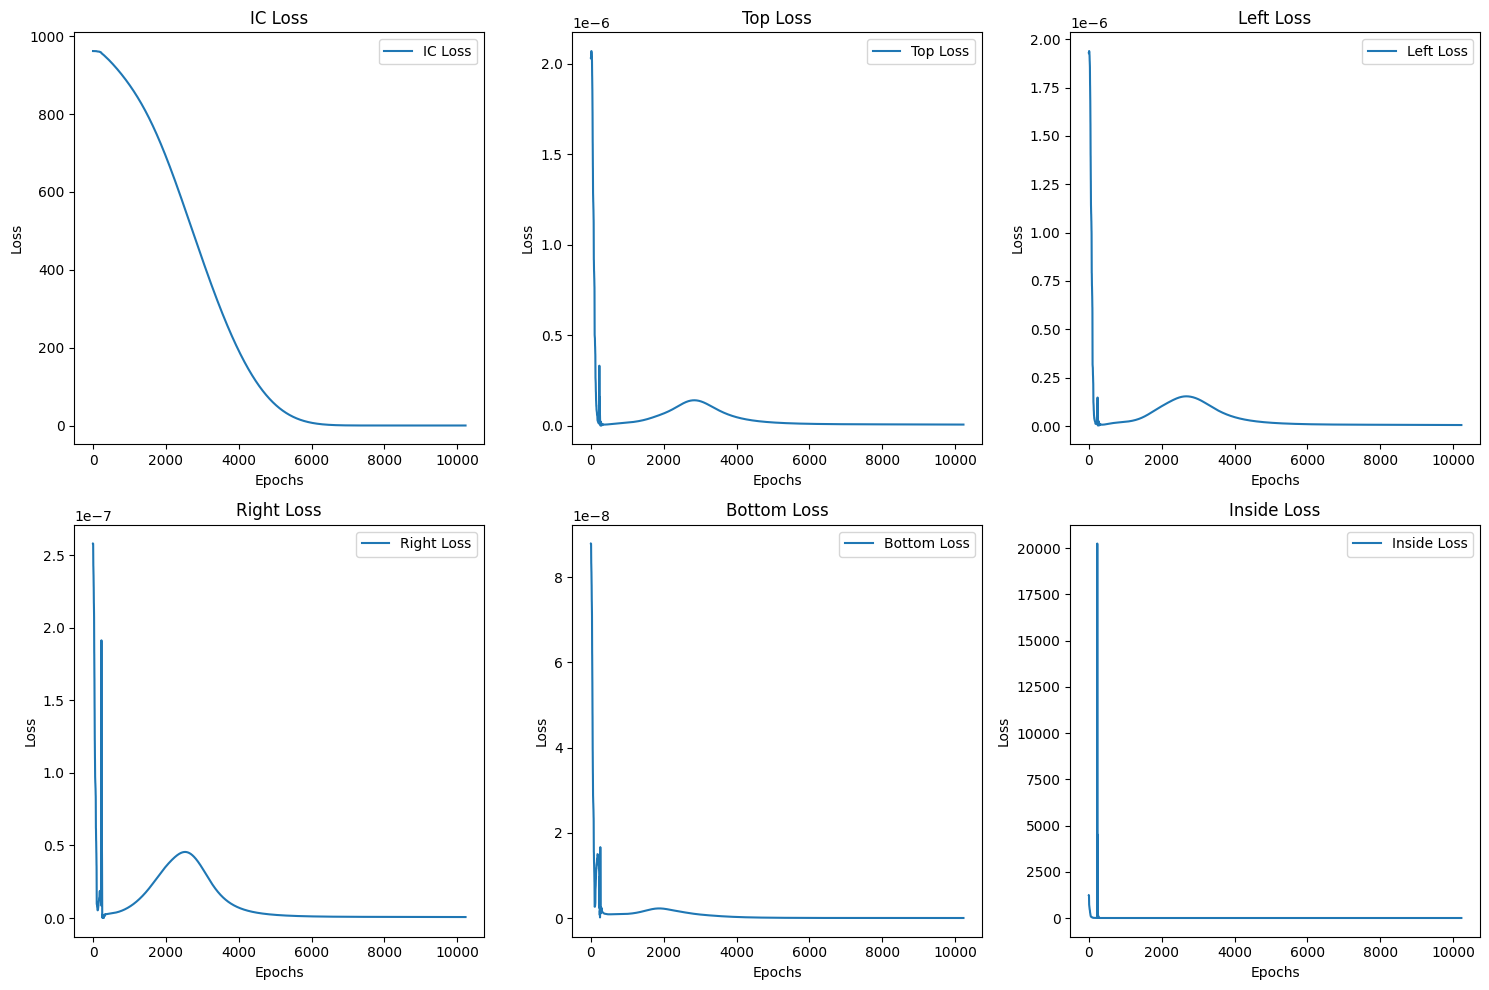

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Given parameters
delta_T = 50 # K
rb_star = 20e-6 # m
lc = rb_star
rb = rb_star / lc
A_star = 0.1
P_star = 210 # W
domain_size_star = 100e-6 # m
domain_size = domain_size_star / lc
T_s_star = 1878 # K
T_l_star = 1928 # K
rho__star = 3730 # kg/m^3
Cp_star = 830  # J/kgK
k_star = 33 # W/mK
alph_diff_star = k_star / (rho__star * Cp_star)
k_cap = 4.02
Lamda = 1.08e-6
alpha_star = 4 * np.pi * k_cap / Lamda
alpha_c = alpha_star
alpha = alpha_star / alpha_c

tau = 5e-6
t_star_max = 5e-6
t_max = t_star_max/tau

x_max_star = domain_size_star
x_max = x_max_star / lc

y_max_star = domain_size_star
y_max = y_max_star / lc

class PhysicsInformedNN():
    def __init__(self, X_ic, X_b, X_f):
        # Extracting and printing left boundary points
        self.x_left = torch.tensor(X_b[X_b[:, 0] == 0, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_left = torch.tensor(X_b[X_b[:, 0] == 0, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_left = torch.tensor(X_b[X_b[:, 0] == 0, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Left boundary:', self.x_left, self.y_left, self.t_left)

        # Extracting and printing right boundary points
        self.x_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Right boundary:', self.x_right, self.y_right, self.t_right)

        # Extracting and printing bottom boundary points
        self.x_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_bottom = torch.tensor(X_b[X_b[:, 1] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Bottom boundary:', self.x_bottom, self.y_bottom, self.t_bottom)

        # Extracting and printing top boundary points
        self.x_top = torch.tensor(X_b[X_b[:, 1] == 0, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.y_top = torch.tensor(X_b[X_b[:, 1] == 0, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_top = torch.tensor(X_b[X_b[:, 1] == 0, 2].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        print('Top boundary:', self.x_top, self.y_top, self.y_top)

        # Extracting and printing collocation points
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.y_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 2].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        print('Collocation points:', self.x_f, self.y_f, self.t_f)


        
        #initial_condition

        self.x_ic = torch.tensor(X_ic[:, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.y_ic = torch.tensor(X_ic[:, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.t_ic = torch.tensor(X_ic[:, 2].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        print('initial points:', self.x_ic, self.y_ic, self.t_ic)
        # self.x_ic = torch.vstack((self.x_left, self.x_right, self.x_top, self.x_bottom, self.x_f)).to(device)
        # self.y_ic = torch.vstack((self.y_left,self.y_right, self.y_top, self.y_bottom, self.y_f)).to(device)
        # self.t_ic = torch.zeros((self.x_ic.shape[0], 1), dtype=torch.float32).to(device)
        self.theta_ic = torch.full((self.x_ic.shape[0], 1), -31, dtype=torch.float32).to(device)

         # Null vector to test against left:
        self.left_null = torch.zeros((self.x_left.shape[0], 1), dtype=torch.float32).to(device)
        self.top_null = torch.zeros((self.x_top.shape[0], 1), dtype=torch.float32).to(device)
        self.right_null = torch.zeros((self.x_right.shape[0], 1), dtype=torch.float32).to(device)
        self.right_null = torch.zeros((self.x_bottom.shape[0], 1), dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x_f.shape[0], 1), dtype=torch.float32).to(device)
        
        self.create_net()

        self.optimizer1 = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.optimizer = torch.optim.LBFGS(self.net.parameters(),
                                    lr=0.0001,
                                    max_iter=50000,
                                    max_eval=50000,
                                    history_size=100,
                                    line_search_fn="strong_wolfe")
        self.iter = 0
        self.losses = []
        self.ic_losses = []
        self.top_losses = []
        self.left_losses = []
        self.right_losses = []
        self.bottom_losses = []
        self.inside_losses = []
        self.loss = nn.MSELoss()
        
    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(3, 40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40,40), nn.Tanh(),
            nn.Linear(40, 1)
        ).to(device)

    def net_theta(self,x,y,t):
        theta = self.net(torch.hstack((x,y,t)))
        return theta
    
    def net_bc(self, x, y, t):
        theta = self.net_theta(x,y,t)
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        bc = theta_x + theta_y
        return bc
    
    
    def net_inside(self, x, y, t):
        theta = self.net_theta(x,y,t)
        
        theta_t = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_xx = torch.autograd.grad(theta_x, x, torch.ones_like(theta_x), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        theta_yy = torch.autograd.grad(theta_y, y, torch.ones_like(theta_y), create_graph=True)[0]
        
        term1 = ((tau * 2 * A_star * P_star * alpha_c * alpha)/k_star*delta_T*np.pi*(lc**2)*(rb**2))
        term2 = torch.exp(-2*(x**2 + (y - y_max)**2/rb**2))
        term3 = torch.exp(-alpha_c*alpha*lc*abs(y-y_max))
        Q_0 =  term1 * term2 * term3
        
        net_inside = -(1/alph_diff_star)*theta_t + (tau/lc**2)*(theta_xx + theta_yy) + Q_0
        return net_inside
    
    def closure1(self):
        # Reset gradient to zero
        self.optimizer.zero_grad()

        # T prediction at boundary points and collocation points
        theta_ic_prediction = self.net_theta(self.x_ic,self.y_ic,self.t_ic)
        theta_left_prediction = self.net_bc(self.x_left, self.y_left,self.t_left)
        theta_top_prediction = self.net_bc(self.x_top, self.y_top, self.t_top)
        theta_right_prediction = self.net_bc(self.x_right, self.y_right, self.t_right)
        theta_bottom_prediction = self.net_bc(self.x_bottom, self.y_bottom, self.t_bottom)

        # ic loss
        
        theta_ic_loss = self.loss(theta_ic_prediction, self.theta_ic) 
        # Temperature gradient and losses for the inside condition
        theta_inside_prediction = self.net_inside(self.x_f, self.y_f, self.t_f)
        theta_loss_inside = self.loss(theta_inside_prediction, self.null)

        # losses for the boundary conditions
        theta_left_loss = self.loss(theta_left_prediction, self.left_null)
        theta_top_loss = self.loss(theta_top_prediction, self.top_null)
        theta_right_loss = self.loss(theta_right_prediction, self.right_null)
        theta_bottom_loss = self.loss(theta_bottom_prediction, self.right_null)

        self.ls = theta_ic_loss + theta_top_loss + theta_left_loss + theta_right_loss + theta_bottom_loss + theta_loss_inside
        self.losses.append(self.ls.item())
        self.ic_losses.append(theta_ic_loss.item())
        self.top_losses.append(theta_top_loss.item())
        self.left_losses.append(theta_left_loss.item())
        self.right_losses.append(theta_right_loss.item())
        self.bottom_losses.append(theta_bottom_loss.item())
        self.inside_losses.append(theta_loss_inside.item())

        # Check for NaN values
        if torch.isnan(self.ls):
            print("Loss is NaN. Stopping training.")
            return self.ls

        # derivative with respect to net's weights
        self.ls.backward()
        self.optimizer1.step()
        # increase iteration count
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print(f"Epochs: {self.iter} Total Loss: {self.ls} Top Loss: {theta_top_loss} Left Loss: {theta_left_loss} Right loss: {theta_right_loss} Bottom loss: {theta_bottom_loss} device {device}")

        return self.ls

    def closure(self):
        # Reset gradient to zero
        self.optimizer.zero_grad()

        # T prediction at boundary points and collocation points
        theta_ic_prediction = self.net_theta(self.x_ic,self.y_ic,self.t_ic)
        theta_left_prediction = self.net_bc(self.x_left, self.y_left,self.t_left)
        theta_top_prediction = self.net_bc(self.x_top, self.y_top, self.t_top)
        theta_right_prediction = self.net_bc(self.x_right, self.y_right, self.t_right)
        theta_bottom_prediction = self.net_bc(self.x_bottom, self.y_bottom, self.t_bottom)

        # ic loss
        
        theta_ic_loss = self.loss(theta_ic_prediction, self.theta_ic) 
        # Temperature gradient and losses for the inside condition
        theta_inside_prediction = self.net_inside(self.x_f, self.y_f, self.t_f)
        theta_loss_inside = self.loss(theta_inside_prediction, self.null)

        # losses for the boundary conditions
        theta_left_loss = self.loss(theta_left_prediction, self.left_null)
        theta_top_loss = self.loss(theta_top_prediction, self.top_null)
        theta_right_loss = self.loss(theta_right_prediction, self.right_null)
        theta_bottom_loss = self.loss(theta_bottom_prediction, self.right_null)

        self.ls = theta_ic_loss + theta_top_loss + theta_left_loss + theta_right_loss + theta_bottom_loss + theta_loss_inside
        self.losses.append(self.ls.item())
        self.ic_losses.append(theta_ic_loss.item())
        self.top_losses.append(theta_top_loss.item())
        self.left_losses.append(theta_left_loss.item())
        self.right_losses.append(theta_right_loss.item())
        self.bottom_losses.append(theta_bottom_loss.item())
        self.inside_losses.append(theta_loss_inside.item())

        # Check for NaN values
        if torch.isnan(self.ls):
            print("Loss is NaN. Stopping training.")
            return self.ls

        # derivative with respect to net's weights
        self.ls.backward()
        # self.optimizer.step()
        # increase iteration count
        self.iter += 1

        # print report:
        if not self.iter % 100:
            print(f"Epochs: {self.iter} Total Loss: {self.ls} Top Loss: {theta_top_loss} Left Loss: {theta_left_loss} Right loss: {theta_right_loss} Bottom loss: {theta_bottom_loss} device {device}")

        return self.ls
    
    def train(self, epochs = 20000):
        self.net.train()
        self.optimizer.step(self.closure)
        for _ in range(epochs):
            self.closure1()      
        self.plot_losses()
        
    def predict(self,x,y,t):
        self.net.eval()
        x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
        t = torch.tensor(t, dtype=torch.float32,requires_grad=True)
        theta = self.net_theta(x,y,t)
        return theta
    
    def save_model(self, file_path):
      torch.save(self.net.state_dict(), file_path)

    def load_model(self, file_path):
      self.net.load_state_dict(torch.load(file_path))
    

    def plot_losses(self):
        epochs = range(len(self.losses))
        fig, axs = plt.subplots(2, 3, figsize=(15, 10))

        axs[0, 0].plot(epochs, self.ic_losses, label='IC Loss')
        axs[0, 0].set_title('IC Loss')
        axs[0, 0].set_xlabel('Epochs')
        axs[0, 0].set_ylabel('Loss')
        axs[0, 0].legend()

        axs[0, 1].plot(epochs, self.top_losses, label='Top Loss')
        axs[0, 1].set_title('Top Loss')
        axs[0, 1].set_xlabel('Epochs')
        axs[0, 1].set_ylabel('Loss')
        axs[0, 1].legend()

        axs[0, 2].plot(epochs, self.left_losses, label='Left Loss')
        axs[0, 2].set_title('Left Loss')
        axs[0, 2].set_xlabel('Epochs')
        axs[0, 2].set_ylabel('Loss')
        axs[0, 2].legend()

        axs[1, 0].plot(epochs, self.right_losses, label='Right Loss')
        axs[1, 0].set_title('Right Loss')
        axs[1, 0].set_xlabel('Epochs')
        axs[1, 0].set_ylabel('Loss')
        axs[1, 0].legend()

        axs[1, 1].plot(epochs, self.bottom_losses, label='Bottom Loss')
        axs[1, 1].set_title('Bottom Loss')
        axs[1, 1].set_xlabel('Epochs')
        axs[1, 1].set_ylabel('Loss')
        axs[1, 1].legend()

        axs[1, 2].plot(epochs, self.inside_losses, label='Inside Loss')
        axs[1, 2].set_title('Inside Loss')
        axs[1, 2].set_xlabel('Epochs')
        axs[1, 2].set_ylabel('Loss')
        axs[1, 2].legend()

        plt.tight_layout()
        plt.show()
            
    
    
if __name__ == "__main__":
    N_theta = 10000
    N_F = 10000

    
    
    
    # Left boundary
    x_left_star = np.zeros((N_theta//4, 1), dtype=float)
    y_left_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    t_left_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_left = x_left_star / lc
    y_left = y_left_star / lc
    t_left = t_left_star / tau


    # Right boundary
    x_right_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    y_right_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    t_right_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_right = x_right_star / lc
    y_right = y_right_star / lc
    t_right = t_right_star / tau


    
    # Bottom boundary
    x_bottom_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_bottom_star = np.zeros((N_theta//4, 1), dtype=float)
    t_bottom_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_bottom = x_bottom_star / lc
    y_bottom = y_bottom_star / lc
    t_bottom = t_bottom_star / tau

    # Top boundary
    x_top_star = np.random.uniform(0, domain_size_star, (N_theta//4, 1))
    y_top_star = np.full((N_theta//4, 1), domain_size_star, dtype=float)
    t_top_star = np.random.uniform(0, t_star_max, (N_theta//4, 1))

    x_top = x_top_star / lc
    y_top = y_top_star / lc
    t_top = t_top_star / tau

    # collocation points
    x_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    y_f_star = np.random.uniform(0, domain_size_star, (N_F, 1))
    t_f_star = np.random.uniform(0, t_star_max, (N_F, 1))

    x_f = x_f_star / lc
    y_f = y_f_star / lc
    t_f = t_f_star / tau

   
    
    # stacking the datapoints for training
    
    '''
    boundary points:
    '''
    x_b = np.vstack((x_left, x_right, x_bottom, x_top))    
    y_b = np.vstack((y_left, y_right, y_bottom, y_top))
    t_b = np.vstack((t_left, t_right, t_bottom, t_top))
    X_b = np.hstack((x_b, y_b, t_b))
    
    '''
    collocation points:
    '''
    x_f = x_f.reshape(-1, 1)
    y_f = y_f.reshape(-1, 1)
    t_f = t_f.reshape(-1, 1)
    X_f = np.hstack((x_f, y_f, t_f))

    # initial condition
    x_ic = np.vstack((x_b,x_f))
    y_ic = np.vstack((y_b, y_f))
    t_ic = np.full_like(x_ic, 0.0)

    X_ic = np.hstack((x_ic,y_ic, t_ic))
    
    # Plot the points with different colors for each boundary
    plt.figure(figsize=(8, 6))
    plt.scatter(x_left, y_left, c='blue', label='Left boundary')
    plt.scatter(x_right, y_right, c='red', label='Right boundary')
    plt.scatter(x_bottom, y_bottom, c='green', label='Bottom boundary')
    plt.scatter(x_top, y_top, c='purple', label='Top boundary')
    plt.scatter(x_f, y_f, c='orange', label='Collocation points', alpha=0.5)
    plt.xlim(0, domain_size)
    plt.ylim(0, domain_size)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Boundary Points')
    plt.legend()
    plt.grid(True)
    plt.show()


    pinn = PhysicsInformedNN(X_ic, X_b, X_f)
    pinn.train()
    pinn.save_model('model-0.pth')
    # pinn.load_model('model-0.pth')


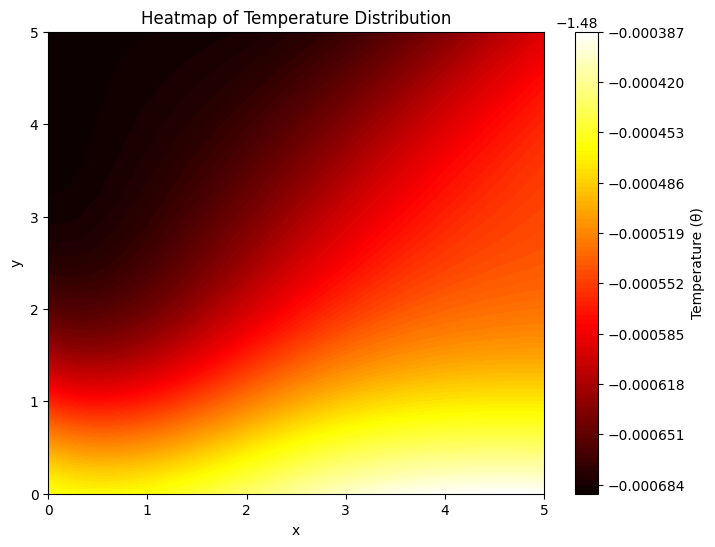

In [11]:
# Set the grid size for the heatmap
n_grid = 100
x_grid = np.linspace(0, domain_size, n_grid)
y_grid = np.linspace(0, domain_size, n_grid)
X, Y = np.meshgrid(x_grid, y_grid)

# Flatten the grid arrays to create input arrays for the model
x_flat = X.flatten()
y_flat = Y.flatten()
t_flat = np.full_like(x_flat, t_max)  # Assuming we want to plot at the final time step

# Convert to torch tensors and move to the same device as the model
x_flat_tensor = torch.tensor(x_flat, dtype=torch.float32, device=device).reshape(-1, 1)
y_flat_tensor = torch.tensor(y_flat, dtype=torch.float32, device=device).reshape(-1, 1)
t_flat_tensor = torch.tensor(t_flat, dtype=torch.float32, device=device).reshape(-1, 1)

# Use the model to predict temperature at each point in the grid
with torch.no_grad():
    theta_pred = pinn.net_theta(x_flat_tensor, y_flat_tensor, t_flat_tensor)

# Reshape the predictions to match the grid shape
Theta = theta_pred.cpu().numpy().reshape(n_grid, n_grid)

# Plot the heatmap
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Theta, cmap='hot', levels=100)
plt.colorbar(contour, label='Temperature (θ)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Temperature Distribution')
plt.show()


torch.Size([1400, 1])

In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Given parameters
delta_T = 50 # K
rb_star = 20e-6 # m
lc = rb_star
rb = rb_star / lc
A_star = 0.1
P_star = 210 # W
domain_size_star = 100e-6 # m
domain_size = domain_size_star / lc
T_s_star = 1878 # K
T_l_star = 1928 # K
rho__star = 3730 # kg/m^3
Cp_star = 830  # J/kgK
k_star = 33 # W/mK
alph_diff_star = k_star / (rho__star * Cp_star)
k_cap = 4.02
Lamda = 1.08e-6
alpha_star = 4 * np.pi * k_cap / Lamda
alpha_c = alpha_star
alpha = alpha_star / alpha_c

tau = 5e-6
t_star_max = 5e-6
t_max = t_star_max/tau

x_max_star = domain_size_star
x_max = x_max_star / lc

y_max_star = domain_size_star
y_max = y_max_star / lc

class PhysicsInformedNN():
    def __init__(self, X_b, X_f):
        # Extract boundary points
        self.x_left = torch.tensor(X_b[X_b[:, 0] == 0, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_left = torch.tensor(X_b[X_b[:, 0] == 0, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_left = torch.tensor(X_b[X_b[:, 0] == 0, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Left boundary:', self.x_left, self.y_left, self.t_left)

        self.x_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_right = torch.tensor(X_b[X_b[:, 0] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Right boundary:', self.x_right, self.y_right, self.t_right)

        self.x_top = torch.tensor(X_b[X_b[:, 1] == domain_size, 0].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.y_top = torch.tensor(X_b[X_b[:, 1] == domain_size, 1].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        self.t_top = torch.tensor(X_b[X_b[:, 1] == domain_size, 2].reshape(-1, 1),
                            dtype=torch.float32,
                            requires_grad=True).to(device)
        print('Top boundary:', self.x_top, self.y_top, self.t_top)

        self.x_bottom = torch.tensor(X_b[X_b[:, 1] == 0, 0].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.y_bottom = torch.tensor(X_b[X_b[:, 1] == 0, 1].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        self.t_bottom = torch.tensor(X_b[X_b[:, 1] == 0, 2].reshape(-1, 1),
                                dtype=torch.float32,
                                requires_grad=True).to(device)
        print('Bottom boundary:', self.x_bottom, self.y_bottom, self.t_bottom)

        # Extract collocation points
        self.x_f = torch.tensor(X_f[:, 0].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.y_f = torch.tensor(X_f[:, 1].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        self.t_f = torch.tensor(X_f[:, 2].reshape(-1, 1),
                                    dtype=torch.float32,
                                    requires_grad=True).to(device)
        print('Collocation points:', self.x_f, self.y_f, self.t_f)

        self.x_ic = torch.vstack((self.x_left, self.x_right, self.x_top, self.x_bottom, self.x_f)).to(device)
        self.y_ic = torch.vstack((self.y_left, self.y_right, self.y_top, self.y_bottom, self.y_f)).to(device)
        self.t_ic = torch.zeros((self.x_ic.shape[0], 1), dtype=torch.float32).to(device)
        self.theta_ic = torch.full((self.x_ic.shape[0], 1), -31, dtype=torch.float32).to(device)

        self.left_null = torch.zeros((self.x_left.shape[0], 1), dtype=torch.float32).to(device)
        self.top_null = torch.zeros((self.x_top.shape[0], 1), dtype=torch.float32).to(device)
        self.right_null = torch.zeros((self.x_right.shape[0], 1), dtype=torch.float32).to(device)
        self.bottom_null = torch.zeros((self.x_bottom.shape[0], 1), dtype=torch.float32).to(device)

        self.null = torch.zeros((self.x_f.shape[0], 1), dtype=torch.float32).to(device)

        self.create_net()

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=1e-3)
        self.iter = 0
        self.losses = []
        self.ic_losses = []
        self.top_losses = []
        self.left_losses = []
        self.right_losses = []
        self.bottom_losses = []
        self.inside_losses = []
        self.loss = nn.MSELoss()

    def create_net(self):
        self.net = nn.Sequential(
            nn.Linear(3, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 40), nn.Tanh(),
            nn.Linear(40, 1)
        ).to(device)

    def net_theta(self, x, y, t):
        theta = self.net(torch.hstack((x, y, t)))
        return theta

    def net_bc(self, x, y, t):
        theta = self.net_theta(x,y,t)
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        bc = theta_x + theta_y
        return bc

    def net_inside(self, x, y, t):
        theta = self.net_theta(x,y,t)
        
        theta_t = torch.autograd.grad(theta, t, torch.ones_like(theta), create_graph=True)[0]
        theta_x = torch.autograd.grad(theta, x, torch.ones_like(theta), create_graph=True)[0]
        theta_xx = torch.autograd.grad(theta_x, x, torch.ones_like(theta_x), create_graph=True)[0]
        theta_y = torch.autograd.grad(theta, y, torch.ones_like(theta), create_graph=True)[0]
        theta_yy = torch.autograd.grad(theta_y, y, torch.ones_like(theta_y), create_graph=True)[0]
        
        term1 = ((tau * 2 * A_star * P_star * alpha_c * alpha)/k_star*delta_T*np.pi*lc**2*rb**2)
        term2 = torch.exp(-2*(x**2 + (y - y_max)**2/rb**2))
        term3 = torch.exp(-alpha_c*alpha*lc*abs(y-y_max))
        Q_0 =  term1 * term2 * term3
        
        net_inside = -(1/alph_diff_star)*theta_t + (tau/lc**2)*(theta_xx + theta_yy) + Q_0
        return net_inside

    def closure(self):
        self.optimizer.zero_grad()
        theta_left = self.net_bc(self.x_left, self.y_left, self.t_left)
        theta_right = self.net_bc(self.x_right, self.y_right, self.t_right)
        theta_top= self.net_bc(self.x_top, self.y_top, self.t_top)
        theta_bottom= self.net_bc(self.x_bottom, self.y_bottom, self.t_bottom)
        theta_inside= self.net_inside(self.x_f, self.y_f, self.t_f)

        ic_pred = self.net_theta(self.x_ic, self.y_ic, self.t_ic)
        ic_loss = self.loss(ic_pred, self.theta_ic)
        self.ic_losses.append(ic_loss.item())

        left_loss = self.loss(theta_left, self.left_null)
        self.left_losses.append(left_loss.item())

        top_loss = self.loss(theta_top, self.top_null)
        self.top_losses.append(top_loss.item())

        right_loss = self.loss(theta_right, self.right_null)
        self.right_losses.append(right_loss.item())

        bottom_loss = self.loss(theta_bottom, self.bottom_null)
        self.bottom_losses.append(bottom_loss.item())

        inside_loss = self.loss(theta_inside, self.null)
        self.inside_losses.append(inside_loss.item())

        loss = ic_loss + left_loss + top_loss + right_loss + bottom_loss + inside_loss
        self.losses.append(loss.item())
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Epochs: {self.iter} Loss:', loss.item())
        return loss

    def train(self, nIter):
        for epoch in range(nIter):
            self.optimizer.step(self.closure)

    def predict(self, X_star):
        x_star = torch.tensor(X_star[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        y_star = torch.tensor(X_star[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        t_star = torch.tensor(X_star[:, 2].reshape(-1, 1), dtype=torch.float32, requires_grad=True).to(device)
        theta_star = self.net_theta(x_star, y_star, t_star)
        return theta_star.cpu().detach().numpy()

# Boundary and initial conditions for training
N_b = 100
N_f = 1000

# Manually define boundary points
x_left = np.zeros((N_b, 1))
y_left = np.random.rand(N_b, 1) * domain_size
t_left = np.random.rand(N_b, 1) * t_max

x_right = np.full((N_b, 1), domain_size)
y_right = np.random.rand(N_b, 1) * domain_size
t_right = np.random.rand(N_b, 1) * t_max

y_top = np.full((N_b, 1), domain_size)
x_top = np.random.rand(N_b, 1) * domain_size
t_top = np.random.rand(N_b, 1) * t_max

y_bottom = np.zeros((N_b, 1))
x_bottom = np.random.rand(N_b, 1) * domain_size
t_bottom = np.random.rand(N_b, 1) * t_max

X_b = np.vstack([np.hstack([x_left, y_left, t_left]),
                 np.hstack([x_right, y_right, t_right]),
                 np.hstack([x_top, y_top, t_top]),
                 np.hstack([x_bottom, y_bottom, t_bottom])])

# Collocation points
x_f = np.random.rand(N_f, 1) * domain_size
y_f = np.random.rand(N_f, 1) * domain_size
t_f = np.random.rand(N_f, 1) * t_max
X_f = np.hstack((x_f, y_f, t_f))

pinn = PhysicsInformedNN(X_b, X_f)
pinn.train(5000)

# Predict and plot
x = np.linspace(0, domain_size, 100)
y = np.linspace(0, domain_size, 100)
t = np.array([1.0])

X, Y = np.meshgrid(x, y)
X_star = np.hstack((X.flatten()[:, None], Y.flatten()[:, None], np.full((X.size, 1), t)))

theta_pred = pinn.predict(X_star)
theta_pred = theta_pred.reshape(X.shape)

plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, theta_pred, cmap='plasma')
plt.colorbar(label='Temperature (θ)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of Temperature Distribution')
plt.show()


Using device: cuda
Left boundary: tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],


KeyboardInterrupt: 